In [2]:
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import Unet, UnetPlusPlus, DeepLabV3Plus, MAnet, FPN
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from segmentation_models_pytorch.utils import train as smp_train
from segmentation_models_pytorch import utils

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.profilers import AdvancedProfiler, SimpleProfiler

from torchmetrics.segmentation import MeanIoU, GeneralizedDiceScore
from torchmetrics import Accuracy, F1Score, Precision, Recall, ConfusionMatrix, AUROC

import os
import cv2
from sklearn.model_selection import train_test_split

import numpy as np
import random
from tqdm.notebook import tqdm
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# LOAD AND DISPLAY TRAIN SET

In [4]:
from torchvision.transforms.functional import hflip
def random_horizontal_flip(image, mask, p=0.5):
    if torch.rand(1).item() < p:
        image = hflip(image)
        mask = hflip(mask)
    return image, mask

class SonarDataset(Dataset):
    def __init__(self, data_paths, mask_paths, resize_size=512, num_patches_per_image=3):
        self.data_paths = data_paths
        self.mask_paths = mask_paths
        self.resize_size = resize_size
        self.num_patches_per_image = num_patches_per_image
        
        # Transformations applied on the patches, NO IMAGENET
        #self.transforms = transforms.Compose([
        #    transforms.ToTensor(),
        #])

        # IMAGENET NORMALIZAZION
        self.transforms = transforms.Compose([
            transforms.ToTensor(),  # Applies only if your data is not already a tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.data_paths) * self.num_patches_per_image

    def __getitem__(self, idx):
        file_idx = idx // self.num_patches_per_image
        data_path = self.data_paths[file_idx]
        mask_path = self.mask_paths[file_idx]

        image = np.load(data_path, mmap_mode='r')
        # take only first 3 channels
        image = image[..., :3]
        
        mask = np.load(mask_path, mmap_mode='r')
        patch_size = image.shape[0]

        max_x = image.shape[1] - patch_size
        if max_x <= 0:
            raise ValueError("Patch size is larger than the image width.")

        x = random.randint(0, max_x)
        image_patch = image[:, x:x + patch_size]
        mask_patch = mask[:, x:x + patch_size]

        if self.resize_size != patch_size:
            image_patch = cv2.resize(image_patch, (self.resize_size, self.resize_size), interpolation=cv2.INTER_NEAREST)
            mask_patch = cv2.resize(mask_patch, (self.resize_size, self.resize_size), interpolation=cv2.INTER_NEAREST)

        # Apply transformations        
        #image_patch = image_patch.astype(np.float32)
        #image_patch = self.transforms(image_patch)  # HWC to CHW format conversion before applying ToTensor
        #mask_patch = mask_patch.astype(np.float32)
        #mask_patch = np.expand_dims(mask_patch, axis=0)  # Adding channel dimension for the mask

        image_patch = self.transforms(image_patch.astype(np.float32))
        mask_patch = torch.tensor(mask_patch, dtype=torch.float32).unsqueeze(0)

        image_patch, mask_patch = random_horizontal_flip(image_patch, mask_patch)

        return image_patch, mask_patch

In [5]:
import pickle

new_split = False
split_file = '/media/ubuntu/E/ML_data/days_split.pkl'

image_dir = '/media/ubuntu/E/ML_data/imgs/'
mask_dir = '/media/ubuntu/E/ML_data/binary_masks/'
files = [f for f in os.listdir(image_dir) if f.endswith('.npy')]

if new_split:
    # split into train/test/val
    days = list(set([f.split('_')[0] for f in files]))
    temp_train_days, test_days = train_test_split(days, test_size=0.1, random_state=1)
    train_days, val_days = train_test_split(temp_train_days, test_size=0.2, random_state=1)
    
    # Saving the lists to a file
    with open(split_file, 'wb') as file:
        pickle.dump(train_days, file)
        pickle.dump(val_days, file)
        pickle.dump(test_days, file)

else:
    with open(split_file, 'rb') as file:
        train_days = pickle.load(file)
        val_days = pickle.load(file)
        test_days = pickle.load(file)

print(val_days, test_days)

['0709', '0716', '0701'] ['0707', '0705']


In [8]:
image_dir = '/media/ubuntu/E/ML_data/imgs/'
mask_dir = '/media/ubuntu/E/ML_data/binary_masks/'
files = [f for f in os.listdir(image_dir) if f.endswith('.npy')]

train_images = [os.path.join(image_dir, f) for f in files if f.split('_')[0] in train_days]
train_masks = [os.path.join(mask_dir, f) for f in files if f.split('_')[0] in train_days]

val_images = [os.path.join(image_dir, f) for f in files if f.split('_')[0] in val_days]
val_masks = [os.path.join(mask_dir, f) for f in files if f.split('_')[0] in val_days]

test_images = [os.path.join(image_dir, f) for f in files if f.split('_')[0] in test_days]
test_masks = [os.path.join(mask_dir, f) for f in files if f.split('_')[0] in test_days]

# Create datasets
train_dataset = SonarDataset(train_images, train_masks)
val_dataset = SonarDataset(val_images, val_masks)
test_dataset = SonarDataset(test_images, test_masks)

batch_size = 4

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [7]:
images, masks = next(iter(train_loader))

print(f'Images shape: {images.shape}')
print(f'Masks shape: {masks.shape}')

Images shape: torch.Size([4, 3, 512, 512])
Masks shape: torch.Size([4, 1, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285715].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3866646].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5157473].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3772476].


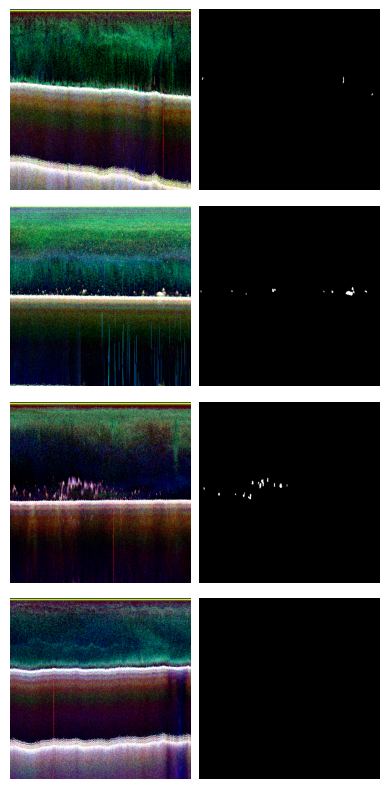

In [8]:
import matplotlib.pyplot as plt

def show_img_mask(loader, num_images_to_display = 4, test = False):
    if test: images, masks, _ = next(iter(loader))    
    else: images, masks = next(iter(loader))   
        
    # Convert tensors to numpy arrays for visualization
    images_np = images.numpy()  # In shape (N, C, H, W)
    masks_np = masks.numpy()  # In shape (N, H, W)
    
    images_np = images_np.transpose((0, 2, 3, 1))
    masks_np = masks_np.transpose((0, 2, 3, 1))
    
    fig, axes = plt.subplots(num_images_to_display, 2, figsize=(4, 2 * num_images_to_display))
    
    for i in range(num_images_to_display):
        # Display the image
        axes[i, 0].imshow(images_np[i], cmap = 'viridis')
        axes[i, 0].axis('off')
    
        # Display the mask
        axes[i, 1].imshow(masks_np[i], cmap='gray')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

show_img_mask(train_loader)

In [78]:
def compute_class_ratio(data_loader):
    class_counts = torch.tensor([0.0, 0.0])
    
    # Loop through all the batches in the DataLoader
    for _, targets in tqdm(data_loader):
        # Assuming targets are binary class labels with 0 and 1
        # Update class counts
        unique, counts = torch.unique(targets, return_counts=True)
        for u, c in zip(unique, counts):
            class_counts[int(u)] += c.item()
    
    # Avoid division by zero
    class_counts = class_counts.clamp(min=1)
    # Calculate ratio
    total = class_counts.sum()
    class_ratios = class_counts / total

    # To set alpha inversely proportional to the class frequencies
    alpha = 1.0 - class_ratios
    return alpha

# Usage
alpha = compute_class_ratio(train_loader)
print("Computed alpha for FocalLoss:", alpha)

  0%|          | 0/164 [00:00<?, ?it/s]

Computed alpha for FocalLoss: tensor([7.3242e-04, 9.9927e-01])


# TRAIN THE MODEL

In [40]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2, logits=True, reduction='mean'):
        """
        Parameters:
        alpha (tensor, optional): Weights for each class. Default is equal weight.
        gamma (int, optional): Focusing parameter. Default is 2.
        logits (bool, optional): If True, expects inputs as raw logits. If False, expects probabilities. Default is True.
        reduction (str, optional): Specifies the reduction to apply to the output: 'none', 'mean', 'sum'. Default is 'mean'.
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha if alpha is not None else torch.tensor([1.0, 1.0])
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets):
        if self.logits:
            # Compute the binary cross-entropy loss with logits
            BCE_loss = torch.nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            # Compute the binary cross-entropy loss
            BCE_loss = torch.nn.functional.binary_cross_entropy(inputs, targets, reduction='none')
        
        # Ensure targets are on the same device as inputs
        targets = targets.to(inputs.device).long()
        # Ensure alpha is on the same device as targets
        self.alpha = self.alpha.to(inputs.device)
        # Dynamic alpha based on target class
        alpha = self.alpha[targets]
        
        # Compute the modulating factor (1 - pt)^gamma
        pt = torch.exp(-BCE_loss)
        focal_loss = alpha * ((1 - pt) ** self.gamma) * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss

class SegModel(pl.LightningModule):
    def __init__(self, model, criterion, optimizer, threshold = 0.5):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.threshold = threshold

        self.iou = MeanIoU(num_classes=2, per_class=True)  
        self.precision = Precision(task="multiclass", num_classes=2, average='none')
        self.recall = Recall(task="multiclass", num_classes=2, average='none')
        self.f1 = F1Score(task="multiclass", num_classes=2, average='none')
        self.dice = GeneralizedDiceScore(num_classes=2, include_background=True, per_class=True)
        self.confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=2)
        self.auroc = AUROC(task="binary")

        self.test_outputs = []
        
    def forward(self, x):
        return self.model(x)
    
    def shared_step(self, batch, stage):
        image, mask = batch
        out = self.forward(image)
        
        # Ensure mask is float for focal loss compatibility
        loss = self.criterion(out, mask.float())  
        
        # Convert logits to binary predictions
        preds = (out.sigmoid() > 0.5).long()
        
        tp, fp, fn, tn = smp.metrics.get_stats(preds, mask.long(), mode='binary')
        iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        self.log(f"{stage}_IoU", iou, prog_bar=True, on_step=False, on_epoch=True)
        self.log(f"{stage}_loss", loss, prog_bar=True, on_step=False, on_epoch=True) 
        return {"loss": loss, "iou": iou}
        
    def training_step(self, batch, batch_idx):
        #torch.cuda.empty_cache()  # Clear cache after each batch
        return self.shared_step(batch, "train")     

    def validation_step(self, batch, batch_idx):
        #torch.cuda.empty_cache()  # Clear cache after each batch
        return self.shared_step(batch, "valid")

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        preds = torch.sigmoid(logits) > self.threshold
        preds = preds.int()  # Convert boolean to integers
        y = y.int()  # Ensure targets are also integers
        
        # Update metrics
        iou_score = self.iou(preds, y)
        dice_score = self.dice(preds, y)
        precision = self.precision(preds, y)
        recall = self.recall(preds, y)
        f1 = self.f1(preds, y)
        cm = self.confusion_matrix(preds, y).float()
        auroc = self.auroc(preds, y)
    
        # Log metrics
        #self.log('iou_score', iou_score, on_step=False, on_epoch=True)
        #self.log('dice_score', dice_score, on_step=False, on_epoch=True)
        #self.log('precision', precision, on_step=False, on_epoch=True)
        #self.log('recall', recall, on_step=False, on_epoch=True)
        #self.log('f1', f1, on_step=False, on_epoch=True)

        outputs = {
            "iou": iou_score,
            "dice": dice_score,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "confusion_matrix": cm,
            "auroc": auroc
        }

        self.test_outputs.append(outputs)
        
        return outputs

    def on_test_epoch_end(self):
        # Aggregate metrics
        iou_scores = torch.stack([x['iou'] for x in self.test_outputs])
        dice_scores = torch.stack([x['dice'] for x in self.test_outputs])
        precisions = torch.stack([x['precision'] for x in self.test_outputs])
        recalls = torch.stack([x['recall'] for x in self.test_outputs])
        f1_scores = torch.stack([x['f1'] for x in self.test_outputs])
        cm_scores = torch.stack([x['confusion_matrix'] for x in self.test_outputs])
        auroc_scores = torch.stack([x['auroc'] for x in self.test_outputs])
            
        # Sum confusion matrices
        sum_cm = cm_scores.sum(dim=0)
        sum_cm_np = sum_cm.cpu().numpy()  # Convert to numpy array
        cm_normalized = sum_cm_np.astype('float') / sum_cm_np.sum(axis=1)[:, np.newaxis]

        avg_auroc = auroc_scores.mean()

        avg_iou_background = iou_scores[:, 0].mean()
        avg_iou_class_of_interest = iou_scores[:, 1].mean()

        avg_dice_background = dice_scores[:, 0].mean()
        avg_dice_class_of_interest = dice_scores[:, 1].mean()
        
        avg_precision_background = precisions[:, 0].mean()
        avg_precision_class_of_interest = precisions[:, 1].mean()
        avg_recall_background = recalls[:, 0].mean()
        avg_recall_class_of_interest = recalls[:, 1].mean()
        avg_f1_background = f1_scores[:, 0].mean()
        avg_f1_class_of_interest = f1_scores[:, 1].mean()
    
        # Log aggregated metrics
        self.log('avg_auroc', avg_auroc)
        
        self.log('avg_iou_background', avg_iou_background)
        self.log('avg_iou_class_of_interest', avg_iou_class_of_interest)
        
        self.log('avg_dice_background', avg_dice_background)
        self.log('avg_dice_class_of_interest', avg_dice_class_of_interest)
        
        self.log('avg_precision_background', avg_precision_background)
        self.log('avg_precision_class_of_interest', avg_precision_class_of_interest)
        self.log('avg_recall_background', avg_recall_background)
        self.log('avg_recall_class_of_interest', avg_recall_class_of_interest)
        self.log('avg_f1_background', avg_f1_background)
        self.log('avg_f1_class_of_interest', avg_f1_class_of_interest)
    
        # Plot the normalized confusion matrix
        plt.figure(figsize=(4, 3))
        sns.heatmap(cm_normalized, annot=True, fmt='.4f', cmap='Blues', xticklabels=['BG', 'Fish'], yticklabels=['BG', 'Fish'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Normalized Confusion Matrix')
        plt.show()
    
        # Clear the outputs for the next epoch
        self.test_outputs = []

    def select_threshold(self, dataloader, device='cuda'):
        self.model.eval()
        results = []
    
        thresholds = torch.arange(0.1, 1, 0.1)
    
        with torch.no_grad():
            for threshold in tqdm(thresholds):
                self.precision.reset()
                self.recall.reset()
                self.f1.reset()
                self.iou.reset()
                iou_list = []
                
                for batch_idx, batch in tqdm(enumerate(dataloader), leave=False):
                    images, masks = batch
                    images = images.to(device)
                    masks = masks.to(device)
                    logits = self.model(images)  
                    preds = torch.sigmoid(logits) > threshold
                    preds = preds.int()  # Convert boolean to integers
                    masks = masks.int()  # Ensure targets are also integers
    
                    #self.iou.update(preds, masks)
                    self.f1.update(preds, masks)
                    self.precision.update(preds, masks)
                    self.recall.update(preds, masks)
                    iou_list.append(self.iou(preds, masks)[1].item())
                    
                average_precision = self.precision.compute()[1].item()
                average_recall = self.recall.compute()[1].item()
                average_f1 = self.f1.compute()[1].item()
                #average_iou = self.iou.compute()[1].item()
                average_iou = np.sum(iou_list) / len(iou_list)
    
                results.append({
                    'Threshold': threshold.item(),
                    'IoU': average_iou,
                    'F1': average_f1,
                    'Precision': average_precision,
                    'Recall': average_recall
                })
    
        df_results = pd.DataFrame(results)
        
        return df_results

    def predict(self, dataloader, output_dir=None):
        self.model.eval()  

        if output_dir is not None and not os.path.exists(output_dir):
            os.makedirs(output_dir)

        with torch.no_grad():
            for batch_idx, batch in enumerate(dataloader):
                # Assuming DataLoader provides both images and filenames
                images, masks = batch

                predictions = self(images)

                # Save each prediction as an npy file with the same name as the input file
                for filename, prediction in zip(filenames, predictions):
                    output_filename = os.path.join(output_dir, filename)
                    np.save(output_filename, prediction.cpu().numpy())


    def configure_optimizers(self):
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.8, patience=10, min_lr=1e-05)
        return {'optimizer': self.optimizer, 'lr_scheduler': scheduler, 'monitor': 'valid_loss'}


In [41]:
torch.set_float32_matmul_precision('medium')

model_name = 'unet'
#model_name = 'deeplabv3plus'
#model_name = 'fpn'
encoder = 'resnet34' 
#encoder = 'efficientnet-b3'
#pretrained = None  
pretrained = 'imagenet'
from_scratch = True

run_name = model_name + '_' + encoder
if pretrained: run_name += '_' + pretrained

version_name = f"{datetime.now().strftime('%d%m-%H%M')}"

run_name += '_' + version_name

classes = 1

model = smp.create_model(model_name,
                         encoder_name = encoder,
                         in_channels = 3,
                         encoder_weights=pretrained,
                         classes = classes).to(device)
   
#criterion = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

# Assuming class 0 is the background and class 1 is the class of interest
# alpha shows relative importance of background vs class
criterion = FocalLoss(alpha=torch.tensor([0.05, 0.95]), gamma=2.0, logits=True)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-03)#, weight_decay=1e-05)

checkpoint = ModelCheckpoint(dirpath = f'./models/checkpoints_{run_name}',
                                   #filename='{epoch:02d}-{valid_IoU:.2f}',
                                   filename='best_model', 
                                   save_top_k=1,
                                   verbose = True, 
                                   monitor = 'valid_loss', 
                                   mode = 'min')
early_stopping = EarlyStopping(monitor='valid_loss', patience=10, mode='min')
lr_monitor = LearningRateMonitor(logging_interval='epoch')

In [23]:
# Load from last checkpoint
if not from_scratch:
    checkpoint_path = os.path.join(f'./models/checkpoints_{model_name}_{encoder}', 'best_model.ckpt')
    pl_model = SegModel.load_from_checkpoint(checkpoint_path, model=model, optimizer=optimizer, criterion=criterion)

# Train from scratch
if from_scratch:
    pl_model = SegModel(model, criterion, optimizer)

profiler = SimpleProfiler()

logger = TensorBoardLogger(
    save_dir="tb_logs",
    name=f'{run_name}'
)

#mp.set_start_method('spawn', force=True)

# Initialize the trainer
trainer = pl.Trainer(
    profiler=profiler,
    num_sanity_val_steps=5,
    logger=logger,
    gradient_clip_val=0.5,
    precision='16-mixed',
    accelerator='gpu',
    max_epochs=100,
    callbacks=[checkpoint, early_stopping, lr_monitor],
    #val_check_interval=0.1  # Validate more frequently
)

trainer.fit(pl_model, train_loader, val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs/fpn_resnet34_imagenet_2406-1058
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params
---------------------------------------------------------------
0 | model            | FPN                       | 23.2 M
1 | criterion        | FocalLoss                 | 0     
2 | iou              | MeanIoU                   | 0     
3 | precision        | MulticlassPrecision       | 0     
4 | recall           | MulticlassRecall          | 0     
5 | f1               | MulticlassF1Score         | 0     
6 | dice             | GeneralizedDiceScore      | 0     
7 | confusion_matrix | MulticlassConfusionMatrix | 0     
8 | auroc            | BinaryAUROC               | 0     
------------------------------------------------------

Sanity Checking: |                                                                                            …

/home/ubuntu/cuda/.venv/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Training: |                                                                                                   …

Validation: |                                                                                                 …

Epoch 0, global step 208: 'valid_loss' reached 0.00082 (best 0.00082), saving model to '/home/ubuntu/SSP/segmentation/models/checkpoints_fpn_resnet34_imagenet_2406-1058/best_model.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 1, global step 416: 'valid_loss' reached 0.00080 (best 0.00080), saving model to '/home/ubuntu/SSP/segmentation/models/checkpoints_fpn_resnet34_imagenet_2406-1058/best_model.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 2, global step 624: 'valid_loss' reached 0.00027 (best 0.00027), saving model to '/home/ubuntu/SSP/segmentation/models/checkpoints_fpn_resnet34_imagenet_2406-1058/best_model.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 3, global step 832: 'valid_loss' was not in top 1


Validation: |                                                                                                 …

Epoch 4, global step 1040: 'valid_loss' reached 0.00024 (best 0.00024), saving model to '/home/ubuntu/SSP/segmentation/models/checkpoints_fpn_resnet34_imagenet_2406-1058/best_model.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 5, global step 1248: 'valid_loss' reached 0.00024 (best 0.00024), saving model to '/home/ubuntu/SSP/segmentation/models/checkpoints_fpn_resnet34_imagenet_2406-1058/best_model.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 6, global step 1456: 'valid_loss' reached 0.00022 (best 0.00022), saving model to '/home/ubuntu/SSP/segmentation/models/checkpoints_fpn_resnet34_imagenet_2406-1058/best_model.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 7, global step 1664: 'valid_loss' reached 0.00019 (best 0.00019), saving model to '/home/ubuntu/SSP/segmentation/models/checkpoints_fpn_resnet34_imagenet_2406-1058/best_model.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 8, global step 1872: 'valid_loss' was not in top 1


Validation: |                                                                                                 …

Epoch 9, global step 2080: 'valid_loss' was not in top 1


Validation: |                                                                                                 …

Epoch 10, global step 2288: 'valid_loss' was not in top 1


Validation: |                                                                                                 …

Epoch 11, global step 2496: 'valid_loss' was not in top 1


Validation: |                                                                                                 …

Epoch 12, global step 2704: 'valid_loss' was not in top 1


Validation: |                                                                                                 …

Epoch 13, global step 2912: 'valid_loss' was not in top 1


Validation: |                                                                                                 …

Epoch 14, global step 3120: 'valid_loss' was not in top 1


Validation: |                                                                                                 …

Epoch 15, global step 3328: 'valid_loss' was not in top 1
FIT Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                 	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                

In [9]:
!nvidia-smi

Mon Jun 24 10:36:54 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   44C    P0             12W /   80W |     488MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# SELECT PROBABILITY THRESHOLD

  0%|          | 0/9 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

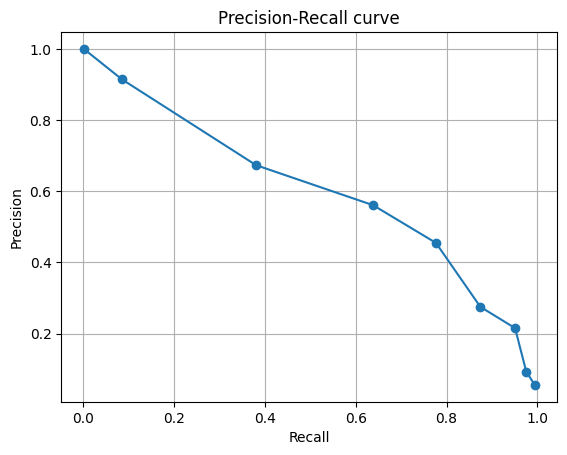

,Threshold,IoU,F1,Precision,Recall
0,0.1,0.045491,0.105539,0.055727,0.994422
1,0.2,0.089471,0.170378,0.093338,0.975697
2,0.3,0.167307,0.351176,0.215344,0.951105
3,0.4,0.217444,0.418573,0.275118,0.874635
4,0.5,0.303000,0.573729,0.454853,0.776727
5,0.6,0.283898,0.597062,0.560822,0.638308
6,0.7,0.207701,0.486135,0.673302,0.380393
7,0.8,0.048520,0.154745,0.914712,0.084522
8,0.9,0.000535,0.001640,1.000000,0.000820


In [43]:
model_name = 'unet'
#model_name = 'deeplabv3plus'
#model_name = 'fpn'
encoder = 'resnet34' 
#encoder = 'efficientnet-b3'
#pretrained = None  
pretrained = 'imagenet'

run_name = model_name + '_' + encoder
if pretrained: run_name += '_' + pretrained

classes = 1
model = smp.create_model(model_name,
                         encoder_name = encoder,
                         in_channels = 3,
                         encoder_weights=pretrained,
                         classes = classes).to(device)

criterion = FocalLoss(alpha=torch.tensor([0.05, 0.95]), gamma=2.0, logits=True)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-03)#, weight_decay=1e-05)

checkpoint_path = os.path.join(f'./models/checkpoints_{run_name}', 'best_model-v2.ckpt')
trained_model = SegModel.load_from_checkpoint(checkpoint_path, model=model, optimizer=optimizer, criterion=criterion)

results = trained_model.select_threshold(val_loader)

plt.figure()
plt.plot(results['Recall'], results['Precision'], marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.grid(True)
plt.show()

results

# TEST THE MODEL

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


./models/checkpoints_unet_resnet34_imagenet/best_model-v2.ckpt


  0%|          | 0/10 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

/home/ubuntu/cuda/.venv/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


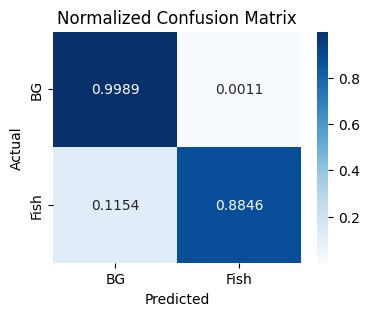

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                   DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           avg_auroc                 0.9192707538604736
      avg_dice_background            0.5000421404838562
  avg_dice_class_of_interest         0.5000421404838562
       avg_f1_background             0.9993833899497986
   avg_f1_class_of_interest          0.5150044560432434
      avg_iou_background             0.3597296178340912
   avg_iou_class_of_interest         0.3597296178340912
   avg_precision_background          0.9999158978462219
avg_precision_class_of_interest      0.3884926438331604
     avg_recall_background           0.9988524913787842
 avg_recall_class_of_interest        0.8653256297111511
─────────────────────────────────────────────────────────────────────────────────────────

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

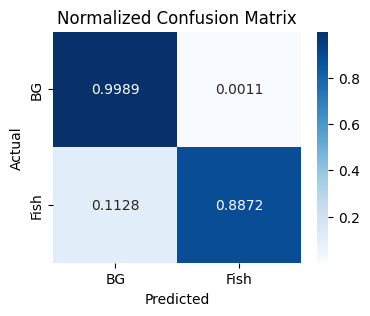

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                   DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           avg_auroc                 0.9433355331420898
      avg_dice_background            0.5084866881370544
  avg_dice_class_of_interest         0.5084866881370544
       avg_f1_background             0.9994021058082581
   avg_f1_class_of_interest          0.5284380912780762
      avg_iou_background             0.3662368059158325
   avg_iou_class_of_interest         0.3662368059158325
   avg_precision_background          0.9999170899391174
avg_precision_class_of_interest      0.39813145995140076
     avg_recall_background           0.9988884925842285
 avg_recall_class_of_interest        0.8877823948860168
────────────────────────────────────────────────────────────────────────────────────────

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

/home/ubuntu/cuda/.venv/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


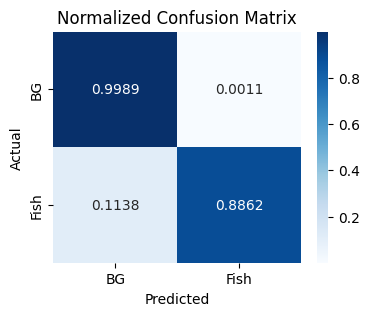

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                   DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           avg_auroc                 0.9199112057685852
      avg_dice_background            0.5012449622154236
  avg_dice_class_of_interest         0.5012449622154236
       avg_f1_background             0.9994004964828491
   avg_f1_class_of_interest          0.5222312211990356
      avg_iou_background             0.3591546416282654
   avg_iou_class_of_interest         0.3591546416282654
   avg_precision_background          0.9999164938926697
avg_precision_class_of_interest      0.3928641974925995
     avg_recall_background           0.9988860487937927
 avg_recall_class_of_interest        0.8665728569030762
─────────────────────────────────────────────────────────────────────────────────────────

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

/home/ubuntu/cuda/.venv/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


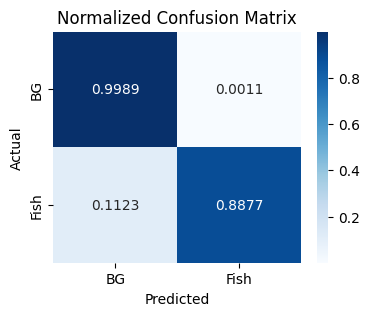

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                   DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           avg_auroc                 0.9214953184127808
      avg_dice_background            0.5094549059867859
  avg_dice_class_of_interest         0.5094549059867859
       avg_f1_background             0.9994187355041504
   avg_f1_class_of_interest          0.5248832106590271
      avg_iou_background             0.3688637316226959
   avg_iou_class_of_interest         0.3688637316226959
   avg_precision_background          0.9999180436134338
avg_precision_class_of_interest      0.39611533284187317
     avg_recall_background           0.9989205598831177
 avg_recall_class_of_interest        0.8697062134742737
────────────────────────────────────────────────────────────────────────────────────────

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

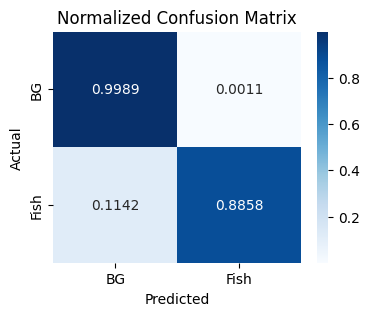

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                   DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           avg_auroc                 0.9460355639457703
      avg_dice_background             0.507827639579773
  avg_dice_class_of_interest          0.507827639579773
       avg_f1_background             0.9993844032287598
   avg_f1_class_of_interest          0.5299710631370544
      avg_iou_background             0.3638361096382141
   avg_iou_class_of_interest         0.3638361096382141
   avg_precision_background          0.9999172687530518
avg_precision_class_of_interest      0.39800727367401123
     avg_recall_background           0.9988530874252319
 avg_recall_class_of_interest        0.8932180404663086
────────────────────────────────────────────────────────────────────────────────────────

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

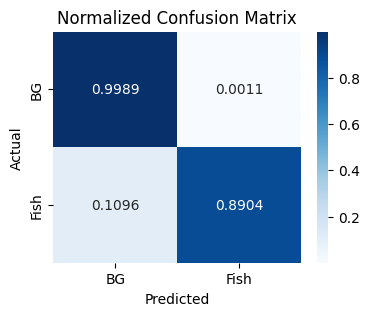

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                   DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           avg_auroc                 0.9458929300308228
      avg_dice_background             0.497638076543808
  avg_dice_class_of_interest          0.497638076543808
       avg_f1_background             0.9993986487388611
   avg_f1_class_of_interest           0.51973557472229
      avg_iou_background             0.35731664299964905
   avg_iou_class_of_interest         0.35731664299964905
   avg_precision_background          0.9999217391014099
avg_precision_class_of_interest      0.3903844952583313
     avg_recall_background           0.9988769292831421
 avg_recall_class_of_interest        0.8929087519645691
────────────────────────────────────────────────────────────────────────────────────────

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

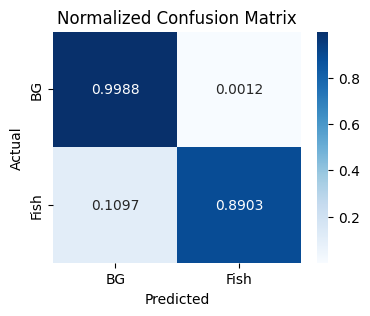

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                   DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           avg_auroc                 0.9478449821472168
      avg_dice_background            0.49600034952163696
  avg_dice_class_of_interest         0.49600034952163696
       avg_f1_background             0.9993761777877808
   avg_f1_class_of_interest          0.5266822576522827
      avg_iou_background             0.35372138023376465
   avg_iou_class_of_interest         0.35372138023376465
   avg_precision_background          0.9999188184738159
avg_precision_class_of_interest      0.3925064206123352
     avg_recall_background           0.9988351464271545
 avg_recall_class_of_interest         0.896854817867279
─────────────────────────────────────────────────────────────────────────────────────

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

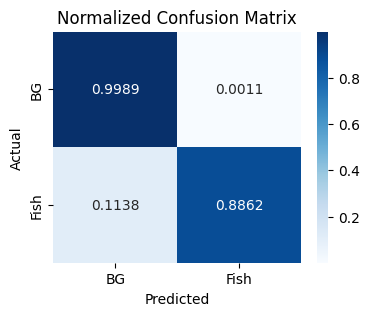

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                   DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           avg_auroc                 0.9472548961639404
      avg_dice_background            0.5019078254699707
  avg_dice_class_of_interest         0.5019078254699707
       avg_f1_background             0.9993959069252014
   avg_f1_class_of_interest          0.5299122333526611
      avg_iou_background             0.36112838983535767
   avg_iou_class_of_interest         0.36112838983535767
   avg_precision_background          0.9999176263809204
avg_precision_class_of_interest      0.3978581726551056
     avg_recall_background           0.9988754391670227
 avg_recall_class_of_interest        0.8956341743469238
───────────────────────────────────────────────────────────────────────────────────────

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

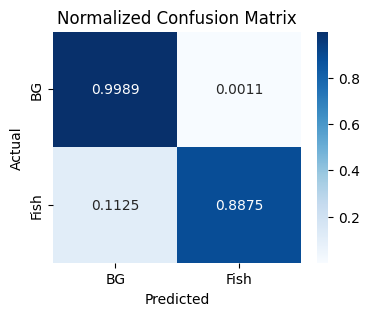

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                   DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           avg_auroc                 0.9449124336242676
      avg_dice_background            0.5074870586395264
  avg_dice_class_of_interest         0.5074870586395264
       avg_f1_background             0.9993883967399597
   avg_f1_class_of_interest          0.5287019610404968
      avg_iou_background             0.36499834060668945
   avg_iou_class_of_interest         0.36499834060668945
   avg_precision_background          0.9999178647994995
avg_precision_class_of_interest      0.3969212770462036
     avg_recall_background           0.9988607168197632
 avg_recall_class_of_interest        0.8909640312194824
───────────────────────────────────────────────────────────────────────────────────────

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

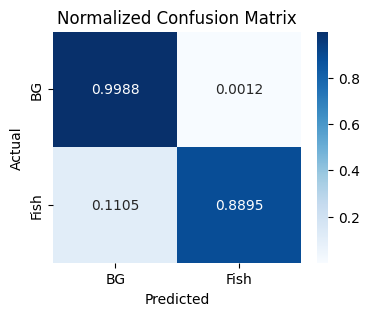

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                   DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           avg_auroc                 0.9404190182685852
      avg_dice_background            0.49785175919532776
  avg_dice_class_of_interest         0.49785175919532776
       avg_f1_background             0.9993743896484375
   avg_f1_class_of_interest          0.5241940021514893
      avg_iou_background             0.35610970854759216
   avg_iou_class_of_interest         0.35610970854759216
   avg_precision_background          0.9999182224273682
avg_precision_class_of_interest      0.39454999566078186
     avg_recall_background           0.9988322257995605
 avg_recall_class_of_interest        0.8820057511329651
────────────────────────────────────────────────────────────────────────────────────

avg_auroc                          0.937637
avg_iou_background                 0.361110
avg_iou_class_of_interest          0.361110
avg_dice_background                0.502794
avg_dice_class_of_interest         0.502794
avg_precision_background           0.999918
avg_precision_class_of_interest    0.394583
avg_recall_background              0.998868
avg_recall_class_of_interest       0.884097
avg_f1_background                  0.999392
avg_f1_class_of_interest           0.524975
dtype: float64

In [25]:
import pandas as pd
import gc

model_name = 'unet'
#model_name = 'deeplabv3plus'
#model_name = 'fpn'
encoder = 'resnet34' 
#encoder = 'efficientnet-b3'
#pretrained = None  
pretrained = 'imagenet'

run_name = model_name + '_' + encoder
if pretrained: run_name += '_' + pretrained

classes = 1
model = smp.create_model(model_name,
                         encoder_name = encoder,
                         in_channels = 3,
                         encoder_weights=pretrained,
                         classes = classes).to(device)

criterion = FocalLoss(alpha=torch.tensor([0.05, 0.95]), gamma=2.0, logits=True)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-03)#, weight_decay=1e-05)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

checkpoint_path = os.path.join(f'./models/checkpoints_{run_name}', 'best_model-v2.ckpt')
trained_model = SegModel.load_from_checkpoint(checkpoint_path, model=model, optimizer=optimizer, criterion=criterion)

tester = pl.Trainer(
    num_sanity_val_steps=5,
    precision='16-mixed',
    accelerator='gpu',
)

print(checkpoint_path)

av_results = pd.DataFrame()
# Since test set uses augmentation, we will average over 10 runs
for i in tqdm(range(0, 10)):
    results = tester.test(trained_model, test_loader)
    gc.collect()
    torch.cuda.empty_cache()
    av_results = pd.concat([av_results, pd.DataFrame(results[0], index=[i])])
av_results.mean()

In [50]:
data = av_results.mean()
# Extract metric types and classes
metric_names = data.index.str.replace('_background', '').str.replace('_class_of_interest', '').unique()
classes = ['background', 'fish']

# Create a dictionary to hold the data
restructured_data = {cls: [] for cls in classes}

# Fill the dictionary with the appropriate values
for metric in metric_names:
    for cls in classes:
        suffix = '_background' if cls == 'background' else '_class_of_interest'
        metric_key = metric + suffix if metric != 'avg_auroc' else metric
        restructured_data[cls].append(data[metric_key])

# Create DataFrame
results_df = pd.DataFrame(restructured_data, index=metric_names)
results_df

,background,fish
avg_auroc,0.937203,0.937203
avg_iou,0.361365,0.361365
avg_dice,0.504524,0.504524
avg_precision,0.999920,0.393673
avg_recall,0.998877,0.885783
avg_f1,0.999398,0.525421


# PLOT PREDICTIONS

In [12]:
model_name = 'unet'
#model_name = 'deeplabv3plus'
#model_name = 'fpn'
encoder = 'resnet34' 
#encoder = 'efficientnet-b3'
#pretrained = None  
pretrained = 'imagenet'

run_name = model_name + '_' + encoder
if pretrained: run_name += '_' + pretrained

classes = 1
model = smp.create_model(model_name,
                         encoder_name = encoder,
                         in_channels = 3,
                         encoder_weights=pretrained,
                         classes = classes).to(device)

criterion = FocalLoss(alpha=torch.tensor([0.05, 0.95]), gamma=2.0, logits=True)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-03)#, weight_decay=1e-05)


n_images = 6
indices = random.sample(range(len(test_dataset)), n_images)
subset = Subset(test_dataset, indices)
test_plot_loader = DataLoader(subset, batch_size=n_images)  # Use batch_size=n_images to load all at once

checkpoint_path = os.path.join(f'./models/checkpoints_{run_name}', 'best_model-v2.ckpt')
trained_model = SegModel.load_from_checkpoint(checkpoint_path, model=model, optimizer=optimizer, criterion=criterion)

tester = pl.Trainer(
    num_sanity_val_steps=5,
    precision='16-mixed',
    accelerator='gpu',
)

images = []
true_masks = []
pred_masks = []

with torch.no_grad():
    for batch in test_plot_loader:
        image, true_mask = batch
        image = image.to('cuda')  # Move image to GPU
        true_mask = true_mask.to('cuda')  # Move true_mask to GPU

        images.extend(image.squeeze().cpu())  # Move back to CPU for plotting
        true_masks.extend(true_mask.squeeze().cpu())  # Move back to CPU for plotting

        # Make prediction
        pred_mask = trained_model(image)
        pred_masks.extend(pred_mask.squeeze().cpu())  # Move back to CPU for plotting

# Ensure the lists have the correct number of elements
assert len(images) == n_images, f"Expected {n_images} images, but got {len(images)}"
assert len(true_masks) == n_images, f"Expected {n_images} true masks, but got {len(true_masks)}"
assert len(pred_masks) == n_images, f"Expected {n_images} predicted masks, but got {len(pred_masks)}"

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ubuntu/cuda/.venv/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.390741].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4610505].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.326235].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4275818].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4116848].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4428558].


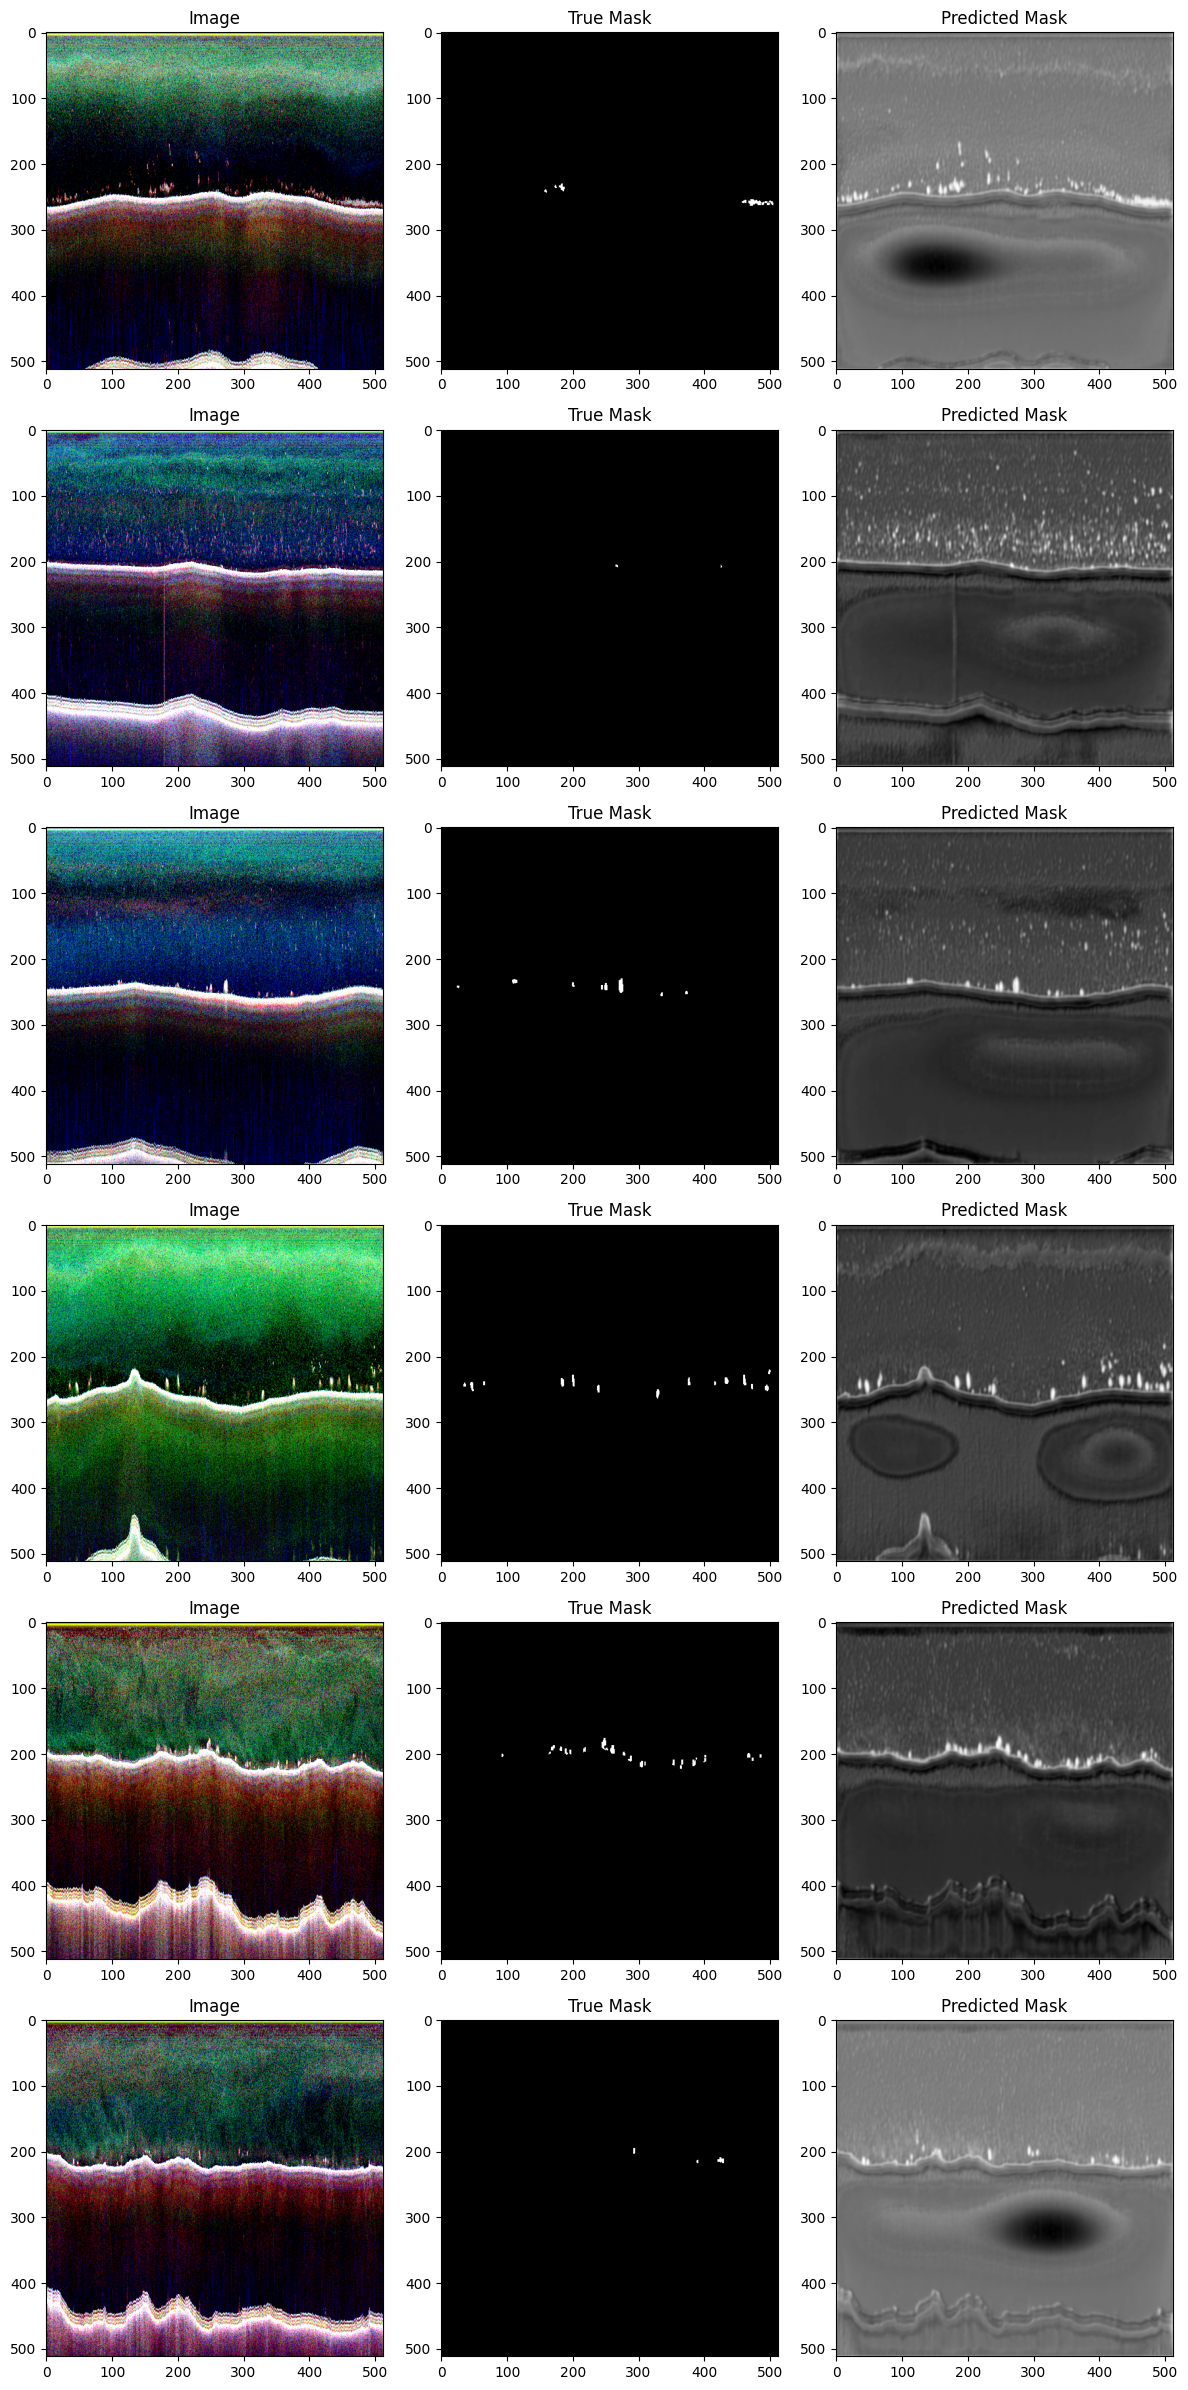

In [13]:
import matplotlib.pyplot as plt

def plot_images(images, true_masks, pred_masks):
    n_images = len(images)
    fig, axes = plt.subplots(n_images, 3, figsize=(12, 4 * n_images))
    
    if n_images == 1:
        axes = [axes]  # Wrap the single set of axes in a list for consistency

    for i in range(n_images):
        axes[i][0].imshow(images[i].cpu().squeeze().permute(1, 2, 0))  # Image
        axes[i][0].set_title("Image")
        axes[i][1].imshow(true_masks[i].cpu().squeeze(), cmap='gray')  # True Mask
        axes[i][1].set_title("True Mask")
        axes[i][2].imshow(pred_masks[i].cpu().squeeze(), cmap='gray')  # Predicted Mask
        axes[i][2].set_title("Predicted Mask")
    
    plt.tight_layout()
    plt.show()

plot_images(images, true_masks, pred_masks) 

# TRAIN AND TEST BASELINE MODEL

In [33]:
import pandas as pd
import itertools
from sklearn.metrics import (
    roc_auc_score, jaccard_score, precision_score, recall_score, f1_score, confusion_matrix
)

def generate_ranges(start, end, step, decimal_places=10):
    values = np.arange(start, end + step, step)
    values = np.round(values, decimals=decimal_places)
    values = values[values <= end]  # Filter to ensure values do not exceed end
    ranges = [(a, b) for a, b in itertools.product(values, repeat=2) if a <= b]
    return ranges

def min_max_normalize(image):
    min_val = np.min(image, axis=(1, 2), keepdims=True)
    max_val = np.max(image, axis=(1, 2), keepdims=True)
    normalized_image = (image - min_val) / (max_val - min_val + 1e-5)
    return normalized_image

def generate_predictions(image_batch, low, high):
    low = np.array(low).reshape((1, -1, 1, 1))
    high = np.array(high).reshape((1, -1, 1, 1))
    preds = np.all((image_batch >= low) & (image_batch <= high), axis=1, keepdims=True).astype(int)
    return preds

def calculate_two_metrics(preds, masks):
    preds_flat = preds.flatten()
    masks_flat = masks.flatten()
    # Calculate IoU for class 1
    iou_score = jaccard_score(masks_flat, preds_flat, pos_label=1, zero_division=0)
    
    if len(np.unique(masks_flat)) > 1:
        auroc_score = roc_auc_score(masks_flat, preds_flat)
    else:
        auroc_score = np.nan  # Assign NaN if AUROC can't be calculated

    return iou_score, auroc_score

def calculate_metrics(preds, masks):
    preds_flat = preds.flatten()
    masks_flat = masks.flatten()
    
    # Calculate metrics for class 1
    precision_class1 = precision_score(masks_flat, preds_flat, pos_label=1, zero_division=0)
    recall_class1 = recall_score(masks_flat, preds_flat, pos_label=1, zero_division=0)
    if precision_class1 + recall_class1 == 0:
        dice_score_class1 = np.nan
    else:
        dice_score_class1 = 2 * (precision_class1 * recall_class1) / (precision_class1 + recall_class1)
    iou_score_class1 = jaccard_score(masks_flat, preds_flat, pos_label=1, zero_division=0)
    f1_class1 = f1_score(masks_flat, preds_flat, pos_label=1)
    
    # Calculate metrics for class 0
    precision_class0 = precision_score(masks_flat, preds_flat, pos_label=0, zero_division=0)
    recall_class0 = recall_score(masks_flat, preds_flat, pos_label=0, zero_division=0)
    if precision_class0 + recall_class0 == 0:
        dice_score_class0 = np.nan
    else:
        dice_score_class0 = 2 * (precision_class0 * recall_class0) / (precision_class0 + recall_class0)
    iou_score_class0 = jaccard_score(masks_flat, preds_flat, pos_label=0, zero_division=0)
    f1_class0 = f1_score(masks_flat, preds_flat, pos_label=0)

    # Calculate AUROC
    if np.any(masks_flat == 1) and np.any(masks_flat == 0):  # Ensure both classes are present
        auroc_score = roc_auc_score(masks_flat, preds_flat)
    else:
        auroc_score = np.nan  # Assign NaN if AUROC can't be calculated

    # Calculate confusion matrix
    cm = confusion_matrix(masks_flat, preds_flat)

    return (iou_score_class0, dice_score_class0, precision_class0, recall_class0, f1_class0), \
           (iou_score_class1, dice_score_class1, precision_class1, recall_class1, f1_class1), auroc_score, cm

def baseline_model_evaluation(data_loader, low, high):
    test_outputs = []

    for images, masks in tqdm(data_loader, desc="Evaluating", total=len(data_loader)):
        images = np.array(images)
        masks = np.array(masks)
        
        images = min_max_normalize(images)
        masks = masks.astype(int)

        preds = generate_predictions(images, [low] * images.shape[1], [high] * images.shape[1])
        metrics_class0, metrics_class1, auroc_score, cm = calculate_metrics(preds, masks)

        test_outputs.append({
            'iou_class0': metrics_class0[0],
            'dice_class0': metrics_class0[1],
            'precision_class0': metrics_class0[2],
            'recall_class0': metrics_class0[3],
            'f1_class0': metrics_class0[4],
            'iou_class1': metrics_class1[0],
            'dice_class1': metrics_class1[1],
            'precision_class1': metrics_class1[2],
            'recall_class1': metrics_class1[3],
            'f1_class1': metrics_class1[4],
            'auroc': auroc_score,
            'confusion_matrix': cm
        })

    # Aggregate metrics
    iou_scores_class0 = np.array([x['iou_class0'] for x in test_outputs])
    dice_scores_class0 = np.array([x['dice_class0'] for x in test_outputs])
    precision_scores_class0 = np.array([x['precision_class0'] for x in test_outputs])
    recall_scores_class0 = np.array([x['recall_class0'] for x in test_outputs])
    f1_scores_class0 = np.array([x['f1_class0'] for x in test_outputs])

    iou_scores_class1 = np.array([x['iou_class1'] for x in test_outputs])
    dice_scores_class1 = np.array([x['dice_class1'] for x in test_outputs])
    precision_scores_class1 = np.array([x['precision_class1'] for x in test_outputs])
    recall_scores_class1 = np.array([x['recall_class1'] for x in test_outputs])
    f1_scores_class1 = np.array([x['f1_class1'] for x in test_outputs])

    auroc_scores = np.array([x['auroc'] for x in test_outputs])

    cm_scores = np.array([x['confusion_matrix'] for x in test_outputs])

    # Sum confusion matrices
    sum_cm = np.sum(cm_scores, axis=0)
    cm_normalized = sum_cm.astype('float') / sum_cm.sum(axis=1)[:, np.newaxis]

    avg_auroc = np.nanmean(auroc_scores)
    avg_iou_class0 = np.mean(iou_scores_class0)
    avg_dice_class0 = np.mean(dice_scores_class0)
    avg_precision_class0 = np.mean(precision_scores_class0)
    avg_recall_class0 = np.mean(recall_scores_class0)
    avg_f1_class0 = np.mean(f1_scores_class0)

    avg_iou_class1 = np.mean(iou_scores_class1)
    avg_dice_class1 = np.mean(dice_scores_class1)
    avg_precision_class1 = np.mean(precision_scores_class1)
    avg_recall_class1 = np.mean(recall_scores_class1)
    avg_f1_class1 = np.mean(f1_scores_class1)

    # Create results dataframe
    results = pd.DataFrame({
        'iou': [avg_iou_class0, avg_iou_class1],
        'dice': [avg_dice_class0, avg_dice_class1],
        'precision': [avg_precision_class0, avg_precision_class1],
        'recall': [avg_recall_class0, avg_recall_class1],
        'f1': [avg_f1_class0, avg_f1_class1],
        'avg_auroc': [avg_auroc, avg_auroc]
    }, index=['background', 'fish'])

    # Plot the normalized confusion matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm_normalized, annot=True, fmt='.4f', cmap='Blues', xticklabels=['BG', 'Fish'], yticklabels=['BG', 'Fish'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Normalized Confusion Matrix')
    plt.show()

    return results.T

def train_baseline_model(data_loader, ranges):
    metrics_dict = {range_pair: {'iou_sum': 0, 'auroc_sum': 0, 'count': 0, 'auroc_count': 0} for range_pair in ranges}
    
    for images, masks in tqdm(data_loader, desc="Training", total=len(data_loader)):
        images = np.array(images)
        masks = np.array(masks)
        
        images = min_max_normalize(images)
        masks = masks.astype(int)  # Ensure masks are integers

        for low, high in ranges:
            preds = generate_predictions(images, [low] * images.shape[1], [high] * images.shape[1])
            iou_score, auroc_score = calculate_two_metrics(preds, masks)

            # Update sums and counts
            metrics_dict[(low, high)]['iou_sum'] += iou_score
            metrics_dict[(low, high)]['count'] += 1

            if not np.isnan(auroc_score):
                metrics_dict[(low, high)]['auroc_sum'] += auroc_score
                metrics_dict[(low, high)]['auroc_count'] += 1

    # Compute averages
    range_metrics = []
    for (low, high), values in metrics_dict.items():
        avg_iou = values['iou_sum'] / values['count']
        if values['auroc_count'] > 0:
            avg_auroc = values['auroc_sum'] / values['auroc_count']
        else:
            avg_auroc = np.nan
        range_metrics.append({'Low': low, 'High': high, 'IoU': avg_iou, 'AUROC': avg_auroc})

    range_metrics_df = pd.DataFrame(range_metrics)
    return range_metrics_df

baseline_train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=1)
ranges = generate_ranges(0.6, 0.9, 0.1)

# Training
range_metrics = train_baseline_model(baseline_train_loader, ranges)
range_metrics

Training:   0%|          | 0/831 [00:00<?, ?it/s]

,Low,High,IoU,AUROC
0,0.6,0.6,0.000000,0.500000
1,0.6,0.7,0.007407,0.556922
2,0.6,0.8,0.011583,0.711207
3,0.6,0.9,0.009981,0.727370
4,0.7,0.7,0.000000,0.500000
5,0.7,0.8,0.011903,0.536351
6,0.7,0.9,0.007802,0.549274
7,0.8,0.8,0.000000,0.500000
8,0.8,0.9,0.001070,0.500779
9,0.9,0.9,0.000000,0.500000


Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

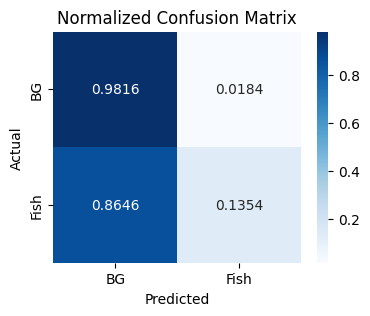

,background,fish
iou,0.981024,0.006100
dice,0.990411,NaN
precision,0.999361,0.006498
recall,0.981639,0.128092
f1,0.990411,0.012008
avg_auroc,0.560648,0.560648


In [30]:
baseline_test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1)
results = baseline_model_evaluation(baseline_test_loader, 0.7, 0.9)
results